In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-part-data/detect/val/PR_curve.png
/kaggle/input/best-part-data/detect/val/P_curve.png
/kaggle/input/best-part-data/detect/val/val_batch0_pred.jpg
/kaggle/input/best-part-data/detect/val/F1_curve.png
/kaggle/input/best-part-data/detect/val/confusion_matrix.png
/kaggle/input/best-part-data/detect/val/val_batch1_pred.jpg
/kaggle/input/best-part-data/detect/val/val_batch2_labels.jpg
/kaggle/input/best-part-data/detect/val/R_curve.png
/kaggle/input/best-part-data/detect/val/confusion_matrix_normalized.png
/kaggle/input/best-part-data/detect/val/val_batch2_pred.jpg
/kaggle/input/best-part-data/detect/val/val_batch1_labels.jpg
/kaggle/input/best-part-data/detect/val/val_batch0_labels.jpg
/kaggle/input/best-part-data/detect/predict/IMG_20211106_163726-Custom-_jpg.rf.f6b102446fe1a2741640046ef32c0a3d.jpg
/kaggle/input/best-part-data/detect/predict/IMG_20211011_153311-Custom-_jpg.rf.797e05957dc05beca80f5e6debde2969.jpg
/kaggle/input/best-part-data/detect/predict/IMG_20211011_16

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.5/974.5 kB 31.2 MB/s eta 0:00:00


In [4]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Loading /kaggle/input/best-part-data/detect/train/weights/best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 180.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 211.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 315.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 10.6s, installed 1 package: ['onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Anthracnose, 11.8ms
Speed: 63.1ms preprocess, 11.8ms inference, 391.4ms postprocess per image at shape (1, 3, 640, 640)


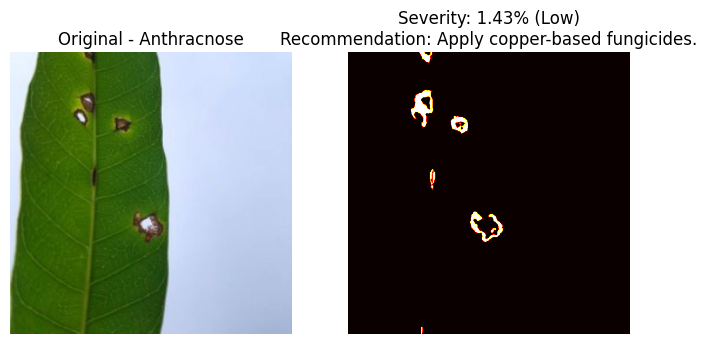

Processing completed.


In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv11 Model
yolo_model = YOLO("/kaggle/input/best-part-data/detect/train/weights/best.onnx")  # Update with actual model path

# Define disease-specific recommendations
disease_recommendations = {
    "Anthracnose": {
        "Low": "Apply copper-based fungicides.",
        "Medium": "Prune infected parts and apply fungicides.",
        "High": "Severely infected leaves should be removed immediately."
    },
    "Powdery Mildew": {
        "Low": "Use neem oil spray as a preventive measure.",
        "Medium": "Apply sulfur-based fungicides.",
        "High": "Quarantine affected plants and apply systemic fungicides."
    },
    "Sooty Mould": {
        "Low": "Wash leaves with mild soap solution.",
        "Medium": "Introduce natural predators like ladybugs.",
        "High": "Apply horticultural oils to remove mold."
    },
    "Gall Midge": {
        "Low": "Use insecticidal soap for control.",
        "Medium": "Remove affected areas and apply neem-based pesticides.",
        "High": "Apply systemic insecticides for severe infestations."
    },
    "Bacterial Canker": {
        "Low": "Apply copper-based sprays.",
        "Medium": "Remove infected branches and disinfect tools.",
        "High": "Apply bactericides and consider tree removal if necessary."
    },
    "Healthy": {"None": "Maintain good agricultural practices."}
}

# Function to classify severity level
def classify_severity(severity):
    if severity == 0:
        return "None"
    elif severity <= 20:
        return "Low"
    elif severity <= 50:
        return "Medium"
    else:
        return "High"

# Process a single image
image_path = "/kaggle/input/dataset-leaf-severity/test/images/20211011_133419-Custom-_jpg.rf.d91a0617fb7a28d17a0da00b4536d716.jpg"  # Update with actual image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Error loading image.")

# Run YOLOv11 model for disease detection
results_yolo = yolo_model(image)
disease_name = "Healthy"
for r in results_yolo:
    if len(r.boxes) > 0:
        disease_name = r.names[int(r.boxes.cls[0].item())]
        break

# Convert to HSV and apply thresholding for infected area segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([15, 60, 30])
upper = np.array([35, 255, 255])
infected_mask = cv2.inRange(hsv, lower, upper)
infected_pixels = cv2.countNonZero(infected_mask)

# Convert to grayscale and detect leaf area
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
leaf_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
leaf_pixels = cv2.countNonZero(leaf_mask)

# Calculate severity percentage
severity = (infected_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0
severity_level = classify_severity(severity)

# Get recommendation
recommendations = disease_recommendations.get(disease_name, {"None": "No data available."})
recommendation = recommendations.get(severity_level, "No treatment needed.")

# Display image, severity, and recommendation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Original - {disease_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(infected_mask, cmap='hot')
plt.title(f"Severity: {severity:.2f}% ({severity_level})\nRecommendation: {recommendation}")
plt.axis("off")

plt.show()

print("Processing completed.")


Loading /kaggle/input/best-part-data/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Anthracnose, 11.6ms
Speed: 3.3ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


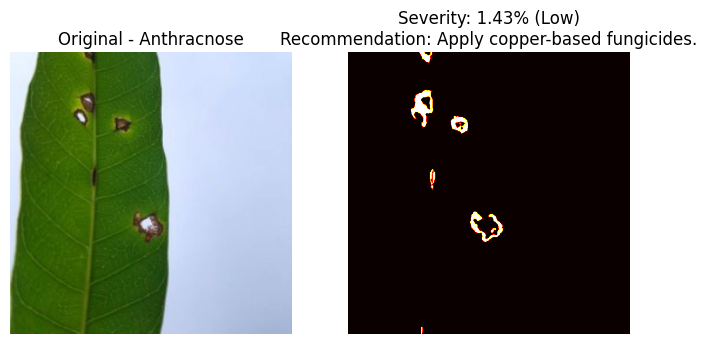

Processing completed.


In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv11 Model
yolo_model = YOLO("/kaggle/input/best-part-data/detect/train/weights/best.onnx")  # Update with actual model path

# Define disease-specific recommendations
disease_recommendations = {
    "Anthracnose": {
        "Low": "Apply copper-based fungicides.",
        "Medium": "Prune infected parts and apply fungicides.",
        "High": "Severely infected leaves should be removed immediately."
    },
    "Powdery Mildew": {
        "Low": "Use neem oil spray as a preventive measure.",
        "Medium": "Apply sulfur-based fungicides.",
        "High": "Quarantine affected plants and apply systemic fungicides."
    },
    "Sooty Mould": {
        "Low": "Wash leaves with mild soap solution.",
        "Medium": "Introduce natural predators like ladybugs.",
        "High": "Apply horticultural oils to remove mold."
    },
    "Gall Midge": {
        "Low": "Use insecticidal soap for control.",
        "Medium": "Remove affected areas and apply neem-based pesticides.",
        "High": "Apply systemic insecticides for severe infestations."
    },
    "Bacterial Canker": {
        "Low": "Apply copper-based sprays.",
        "Medium": "Remove infected branches and disinfect tools.",
        "High": "Apply bactericides and consider tree removal if necessary."
    },
    "Healthy": {"None": "Maintain good agricultural practices."}
}

# Function to classify severity level
def classify_severity(severity):
    if severity == 0:
        return "None"
    elif severity <= 20:
        return "Low"
    elif severity <= 50:
        return "Medium"
    else:
        return "High"

# Process a single image
image_path = "/kaggle/input/dataset-leaf-severity/test/images/20211011_133419-Custom-_jpg.rf.d91a0617fb7a28d17a0da00b4536d716.jpg"  # Update with actual image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Error loading image.")

# Run YOLOv11 model for disease detection
results_yolo = yolo_model(image)
disease_name = "Healthy"
for r in results_yolo:
    if len(r.boxes) > 0:
        disease_name = r.names[int(r.boxes.cls[0].item())]
        break

# Convert to HSV and apply thresholding for infected area segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([15, 60, 30])
upper = np.array([35, 255, 255])
infected_mask = cv2.inRange(hsv, lower, upper)
infected_pixels = cv2.countNonZero(infected_mask)

# Convert to grayscale and detect leaf area
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
leaf_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
leaf_pixels = cv2.countNonZero(leaf_mask)

# Calculate severity percentage
severity = (infected_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0
severity_level = classify_severity(severity)

# Get recommendation
recommendations = disease_recommendations.get(disease_name, {"None": "No data available."})
recommendation = recommendations.get(severity_level, "No treatment needed.")

# Display image, severity, and recommendation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Original - {disease_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(infected_mask, cmap='hot')
plt.title(f"Severity: {severity:.2f}% ({severity_level})\nRecommendation: {recommendation}")
plt.axis("off")

plt.show()

print("Processing completed.")


Loading /kaggle/input/best-part-data/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Anthracnose, 11.6ms
Speed: 3.3ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


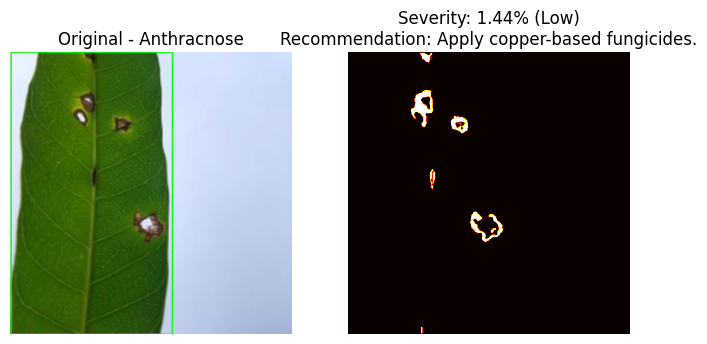

Processing completed.


In [7]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv11 Model
yolo_model = YOLO("/kaggle/input/best-part-data/detect/train/weights/best.onnx")  # Update with actual model path

# Define disease-specific recommendations
disease_recommendations = {
    "Anthracnose": {
        "Low": "Apply copper-based fungicides.",
        "Medium": "Prune infected parts and apply fungicides.",
        "High": "Severely infected leaves should be removed immediately."
    },
    "Powdery Mildew": {
        "Low": "Use neem oil spray as a preventive measure.",
        "Medium": "Apply sulfur-based fungicides.",
        "High": "Quarantine affected plants and apply systemic fungicides."
    },
    "Sooty Mould": {
        "Low": "Wash leaves with mild soap solution.",
        "Medium": "Introduce natural predators like ladybugs.",
        "High": "Apply horticultural oils to remove mold."
    },
    "Gall Midge": {
        "Low": "Use insecticidal soap for control.",
        "Medium": "Remove affected areas and apply neem-based pesticides.",
        "High": "Apply systemic insecticides for severe infestations."
    },
    "Bacterial Canker": {
        "Low": "Apply copper-based sprays.",
        "Medium": "Remove infected branches and disinfect tools.",
        "High": "Apply bactericides and consider tree removal if necessary."
    },
    "Healthy": {"None": "Maintain good agricultural practices."}
}

# Function to classify severity level
def classify_severity(severity):
    if severity == 0:
        return "None"
    elif severity <= 20:
        return "Low"
    elif severity <= 50:
        return "Medium"
    else:
        return "High"

# Process a single image
image_path = "/kaggle/input/dataset-leaf-severity/test/images/20211011_133419-Custom-_jpg.rf.d91a0617fb7a28d17a0da00b4536d716.jpg"  # Update with actual image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Error loading image.")

# Run YOLOv11 model for disease detection
results_yolo = yolo_model(image)
disease_name = "Healthy"
for r in results_yolo:
    if len(r.boxes) > 0:
        disease_name = r.names[int(r.boxes.cls[0].item())]
        for box in r.boxes:
            # Draw bounding box
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get coordinates of the bounding box
            image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# Convert to HSV and apply thresholding for infected area segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([15, 60, 30])
upper = np.array([35, 255, 255])
infected_mask = cv2.inRange(hsv, lower, upper)
infected_pixels = cv2.countNonZero(infected_mask)

# Convert to grayscale and detect leaf area
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
leaf_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
leaf_pixels = cv2.countNonZero(leaf_mask)

# Calculate severity percentage
severity = (infected_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0
severity_level = classify_severity(severity)

# Get recommendation
recommendations = disease_recommendations.get(disease_name, {"None": "No data available."})
recommendation = recommendations.get(severity_level, "No treatment needed.")

# Display image, severity, and recommendation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Original - {disease_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(infected_mask, cmap='hot')
plt.title(f"Severity: {severity:.2f}% ({severity_level})\nRecommendation: {recommendation}")
plt.axis("off")

plt.show()

print("Processing completed.")


Loading /kaggle/input/best-part-data/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Anthracnose, 11.9ms
Speed: 3.5ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


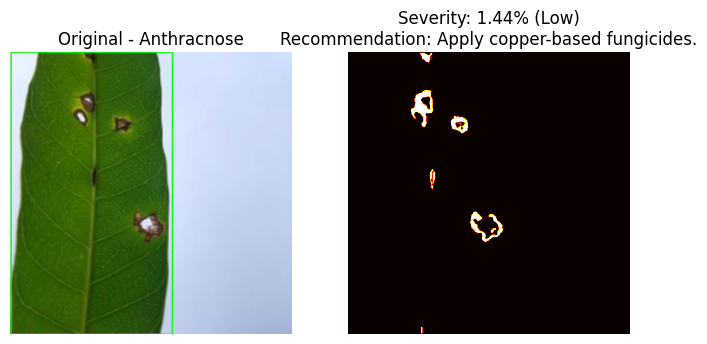

Processing completed.


In [8]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv11 Model
yolo_model = YOLO("/kaggle/input/best-part-data/detect/train/weights/best.onnx")  # Update with actual model path

# Define disease-specific recommendations
disease_recommendations = {
    "Anthracnose": {
        "Low": "Apply copper-based fungicides.",
        "Medium": "Prune infected parts and apply fungicides.",
        "High": "Severely infected leaves should be removed immediately."
    },
    "Powdery Mildew": {
        "Low": "Use neem oil spray as a preventive measure.",
        "Medium": "Apply sulfur-based fungicides.",
        "High": "Quarantine affected plants and apply systemic fungicides."
    },
    "Sooty Mould": {
        "Low": "Wash leaves with mild soap solution.",
        "Medium": "Introduce natural predators like ladybugs.",
        "High": "Apply horticultural oils to remove mold."
    },
    "Gall Midge": {
        "Low": "Use insecticidal soap for control.",
        "Medium": "Remove affected areas and apply neem-based pesticides.",
        "High": "Apply systemic insecticides for severe infestations."
    },
    "Bacterial Canker": {
        "Low": "Apply copper-based sprays.",
        "Medium": "Remove infected branches and disinfect tools.",
        "High": "Apply bactericides and consider tree removal if necessary."
    },
    "Healthy": {"None": "Maintain good agricultural practices."}
}

# Function to classify severity level
def classify_severity(severity):
    if severity == 0:
        return "None"
    elif severity <= 20:
        return "Low"
    elif severity <= 50:
        return "Medium"
    else:
        return "High"

# Process a single image
image_path = "/kaggle/input/dataset-leaf-severity/test/images/20211011_133419-Custom-_jpg.rf.d91a0617fb7a28d17a0da00b4536d716.jpg"  # Update with actual image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Error loading image.")

# Run YOLOv11 model for disease detection
results_yolo = yolo_model(image)
disease_name = "Healthy"
for r in results_yolo:
    if len(r.boxes) > 0:
        disease_name = r.names[int(r.boxes.cls[0].item())]
        for box in r.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get coordinates of the bounding box
            confidence = box.conf[0].item()  # Get confidence score

            # Draw bounding box
            image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            # Add confidence score text on the image
            label = f"{disease_name}: {confidence:.2f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            image = cv2.putText(image, label, (int(x1), int(y1)-10), font, 0.5, (0, 255, 0), 2)

# Convert to HSV and apply thresholding for infected area segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([15, 60, 30])
upper = np.array([35, 255, 255])
infected_mask = cv2.inRange(hsv, lower, upper)
infected_pixels = cv2.countNonZero(infected_mask)

# Convert to grayscale and detect leaf area
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
leaf_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
leaf_pixels = cv2.countNonZero(leaf_mask)

# Calculate severity percentage
severity = (infected_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0
severity_level = classify_severity(severity)

# Get recommendation
recommendations = disease_recommendations.get(disease_name, {"None": "No data available."})
recommendation = recommendations.get(severity_level, "No treatment needed.")

# Display image, severity, and recommendation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Original - {disease_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(infected_mask, cmap='hot')
plt.title(f"Severity: {severity:.2f}% ({severity_level})\nRecommendation: {recommendation}")
plt.axis("off")

plt.show()

print("Processing completed.")


Loading /kaggle/input/best-part-data/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Anthracnose, 11.7ms
Speed: 3.6ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


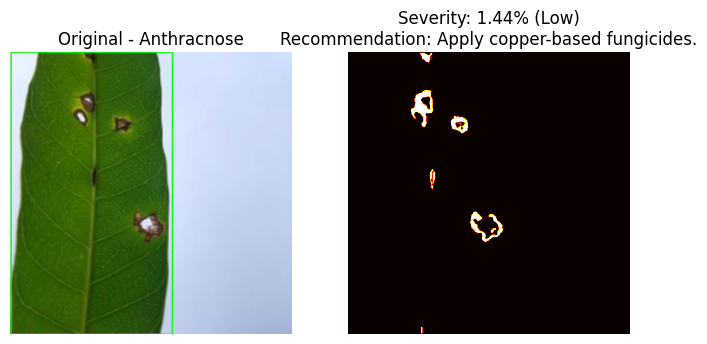

Processing completed.


In [9]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load YOLOv11 Model
yolo_model = YOLO("/kaggle/input/best-part-data/detect/train/weights/best.onnx")  # Update with actual model path

# Define disease-specific recommendations
disease_recommendations = {
    "Anthracnose": {
        "Low": "Apply copper-based fungicides.",
        "Medium": "Prune infected parts and apply fungicides.",
        "High": "Severely infected leaves should be removed immediately."
    },
    "Powdery Mildew": {
        "Low": "Use neem oil spray as a preventive measure.",
        "Medium": "Apply sulfur-based fungicides.",
        "High": "Quarantine affected plants and apply systemic fungicides."
    },
    "Sooty Mould": {
        "Low": "Wash leaves with mild soap solution.",
        "Medium": "Introduce natural predators like ladybugs.",
        "High": "Apply horticultural oils to remove mold."
    },
    "Gall Midge": {
        "Low": "Use insecticidal soap for control.",
        "Medium": "Remove affected areas and apply neem-based pesticides.",
        "High": "Apply systemic insecticides for severe infestations."
    },
    "Bacterial Canker": {
        "Low": "Apply copper-based sprays.",
        "Medium": "Remove infected branches and disinfect tools.",
        "High": "Apply bactericides and consider tree removal if necessary."
    },
    "Healthy": {"None": "Maintain good agricultural practices."}
}

# Function to classify severity level
def classify_severity(severity):
    if severity == 0:
        return "None"
    elif severity <= 20:
        return "Low"
    elif severity <= 50:
        return "Medium"
    else:
        return "High"

# Process a single image
image_path = "/kaggle/input/dataset-leaf-severity/test/images/20211011_133419-Custom-_jpg.rf.d91a0617fb7a28d17a0da00b4536d716.jpg"  # Update with actual image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Error loading image.")

# Run YOLOv11 model for disease detection
results_yolo = yolo_model(image)
disease_name = "Healthy"
for r in results_yolo:
    if len(r.boxes) > 0:
        disease_name = r.names[int(r.boxes.cls[0].item())]
        for box in r.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get coordinates of the bounding box
            confidence = box.conf[0].item()  # Get confidence score

            # Draw bounding box
            image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            # Add confidence score text on the image
            label = f"{disease_name}: {confidence:.2f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            image = cv2.putText(image, label, (int(x1), int(y1)-10), font, 0.5, (0, 255, 0), 2)

# Convert to HSV and apply thresholding for infected area segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([15, 60, 30])
upper = np.array([35, 255, 255])
infected_mask = cv2.inRange(hsv, lower, upper)
infected_pixels = cv2.countNonZero(infected_mask)

# Convert to grayscale and detect leaf area
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
leaf_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
leaf_pixels = cv2.countNonZero(leaf_mask)

# Calculate severity percentage
severity = (infected_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0
severity_level = classify_severity(severity)

# Get recommendation
recommendations = disease_recommendations.get(disease_name, {"None": "No data available."})
recommendation = recommendations.get(severity_level, "No treatment needed.")

# Display image, severity, and recommendation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Use cv2.cvtColor to convert BGR to RGB
plt.title(f"Original - {disease_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(infected_mask, cmap='hot')
plt.title(f"Severity: {severity:.2f}% ({severity_level})\nRecommendation: {recommendation}")
plt.axis("off")

plt.show()

print("Processing completed.")


Loading /kaggle/input/best-part-data/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Anthracnose, 11.8ms
Speed: 3.3ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


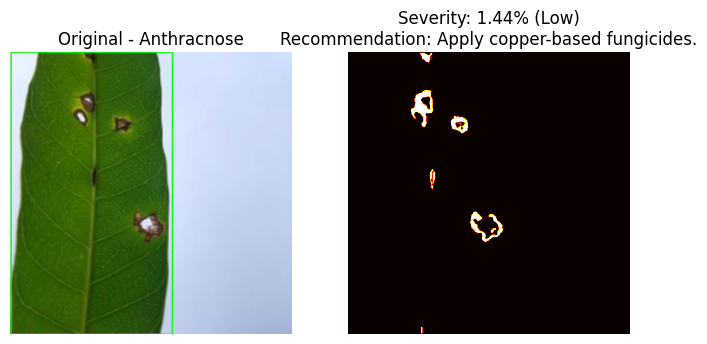

Processing completed.


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Correct path for the uploaded image file
image_path = "/kaggle/input/dataset-leaf-severity/test/images/20211011_133419-Custom-_jpg.rf.d91a0617fb7a28d17a0da00b4536d716.jpg"  # Path to the uploaded image

# Load YOLOv11 Model
yolo_model = YOLO("/kaggle/input/best-part-data/detect/train/weights/best.onnx")  # Update with actual model path

# Define disease-specific recommendations
disease_recommendations = {
    "Anthracnose": {
        "Low": "Apply copper-based fungicides.",
        "Medium": "Prune infected parts and apply fungicides.",
        "High": "Severely infected leaves should be removed immediately."
    },
    "Powdery Mildew": {
        "Low": "Use neem oil spray as a preventive measure.",
        "Medium": "Apply sulfur-based fungicides.",
        "High": "Quarantine affected plants and apply systemic fungicides."
    },
    "Sooty Mould": {
        "Low": "Wash leaves with mild soap solution.",
        "Medium": "Introduce natural predators like ladybugs.",
        "High": "Apply horticultural oils to remove mold."
    },
    "Gall Midge": {
        "Low": "Use insecticidal soap for control.",
        "Medium": "Remove affected areas and apply neem-based pesticides.",
        "High": "Apply systemic insecticides for severe infestations."
    },
    "Bacterial Canker": {
        "Low": "Apply copper-based sprays.",
        "Medium": "Remove infected branches and disinfect tools.",
        "High": "Apply bactericides and consider tree removal if necessary."
    },
    "Healthy": {"None": "Maintain good agricultural practices."}
}

# Function to classify severity level
def classify_severity(severity):
    if severity == 0:
        return "None"
    elif severity <= 20:
        return "Low"
    elif severity <= 50:
        return "Medium"
    else:
        return "High"

# Process a single image
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Error loading image.")

# Run YOLOv11 model for disease detection
results_yolo = yolo_model(image)
disease_name = "Healthy"
for r in results_yolo:
    if len(r.boxes) > 0:
        disease_name = r.names[int(r.boxes.cls[0].item())]
        for box in r.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get coordinates of the bounding box
            confidence = box.conf[0].item()  # Get confidence score

            # Draw bounding box
            image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            # Add confidence score text on the image
            label = f"{disease_name}: {confidence*100:.2f}%"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7  # Control the size of the font
            font_thickness = 2
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
            text_w, text_h = text_size

            # Draw a filled rectangle behind the text for better visibility
            image = cv2.rectangle(image, (int(x1), int(y1) - 20), (int(x1) + text_w, int(y1) - 20 - text_h), (0, 255, 0), -1)
            
            # Now place the text over the filled rectangle
            image = cv2.putText(image, label, (int(x1), int(y1) - 10), font, font_scale, (0, 0, 0), font_thickness)

# Convert to HSV and apply thresholding for infected area segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([15, 60, 30])
upper = np.array([35, 255, 255])
infected_mask = cv2.inRange(hsv, lower, upper)
infected_pixels = cv2.countNonZero(infected_mask)

# Convert to grayscale and detect leaf area
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
leaf_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
leaf_pixels = cv2.countNonZero(leaf_mask)

# Calculate severity percentage
severity = (infected_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0
severity_level = classify_severity(severity)

# Get recommendation
recommendations = disease_recommendations.get(disease_name, {"None": "No data available."})
recommendation = recommendations.get(severity_level, "No treatment needed.")

# Display image, severity, and recommendation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Use cv2.cvtColor to convert BGR to RGB
plt.title(f"Original - {disease_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(infected_mask, cmap='hot')
plt.title(f"Severity: {severity:.2f}% ({severity_level})\nRecommendation: {recommendation}")
plt.axis("off")

plt.show()

print("Processing completed.")


Loading /kaggle/input/best-part-data/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Anthracnose, 12.0ms
Speed: 3.5ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


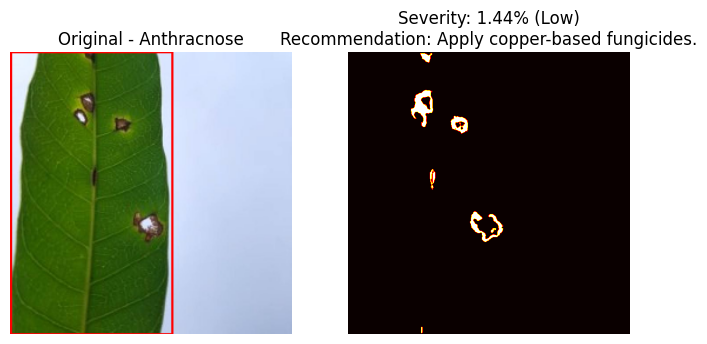

Processing completed.


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Correct path for the uploaded image file
image_path = "/kaggle/input/dataset-leaf-severity/test/images/20211011_133419-Custom-_jpg.rf.d91a0617fb7a28d17a0da00b4536d716.jpg"  # Path to the uploaded image

# Load YOLOv11 Model
yolo_model = YOLO("/kaggle/input/best-part-data/detect/train/weights/best.onnx")  # Update with actual model path

# Define disease-specific recommendations
disease_recommendations = {
    "Anthracnose": {
        "Low": "Apply copper-based fungicides.",
        "Medium": "Prune infected parts and apply fungicides.",
        "High": "Severely infected leaves should be removed immediately."
    },
    "Powdery Mildew": {
        "Low": "Use neem oil spray as a preventive measure.",
        "Medium": "Apply sulfur-based fungicides.",
        "High": "Quarantine affected plants and apply systemic fungicides."
    },
    "Sooty Mould": {
        "Low": "Wash leaves with mild soap solution.",
        "Medium": "Introduce natural predators like ladybugs.",
        "High": "Apply horticultural oils to remove mold."
    },
    "Gall Midge": {
        "Low": "Use insecticidal soap for control.",
        "Medium": "Remove affected areas and apply neem-based pesticides.",
        "High": "Apply systemic insecticides for severe infestations."
    },
    "Bacterial Canker": {
        "Low": "Apply copper-based sprays.",
        "Medium": "Remove infected branches and disinfect tools.",
        "High": "Apply bactericides and consider tree removal if necessary."
    },
    "Healthy": {"None": "Maintain good agricultural practices."}
}

# Function to classify severity level
def classify_severity(severity):
    if severity == 0:
        return "None"
    elif severity <= 20:
        return "Low"
    elif severity <= 50:
        return "Medium"
    else:
        return "High"

# Process a single image
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Error loading image.")

# Run YOLOv11 model for disease detection
results_yolo = yolo_model(image)
disease_name = "Healthy"
for r in results_yolo:
    if len(r.boxes) > 0:
        disease_name = r.names[int(r.boxes.cls[0].item())]
        for box in r.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get coordinates of the bounding box
            confidence = box.conf[0].item()  # Get confidence score

            # Draw bounding box (Red color for better visibility)
            image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 3)

            # Add confidence score text on the image (White text)
            label = f"{disease_name}: {confidence*100:.2f}%"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7  # Control the size of the font
            font_thickness = 2
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
            text_w, text_h = text_size

            # Draw a filled rectangle behind the text for better visibility (Black color)
            image = cv2.rectangle(image, (int(x1), int(y1) - 20), (int(x1) + text_w, int(y1) - 20 - text_h), (0, 0, 0), -1)
            
            # Now place the text over the filled rectangle (White text)
            image = cv2.putText(image, label, (int(x1), int(y1) - 10), font, font_scale, (255, 255, 255), font_thickness)

# Convert to HSV and apply thresholding for infected area segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([15, 60, 30])
upper = np.array([35, 255, 255])
infected_mask = cv2.inRange(hsv, lower, upper)
infected_pixels = cv2.countNonZero(infected_mask)

# Convert to grayscale and detect leaf area
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
leaf_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
leaf_pixels = cv2.countNonZero(leaf_mask)

# Calculate severity percentage
severity = (infected_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0
severity_level = classify_severity(severity)

# Get recommendation
recommendations = disease_recommendations.get(disease_name, {"None": "No data available."})
recommendation = recommendations.get(severity_level, "No treatment needed.")

# Display image, severity, and recommendation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Use cv2.cvtColor to convert BGR to RGB
plt.title(f"Original - {disease_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(infected_mask, cmap='hot')
plt.title(f"Severity: {severity:.2f}% ({severity_level})\nRecommendation: {recommendation}")
plt.axis("off")

plt.show()

print("Processing completed.")


Loading /kaggle/input/best-part-data/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

0: 640x640 1 Anthracnose, 11.7ms
Speed: 3.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


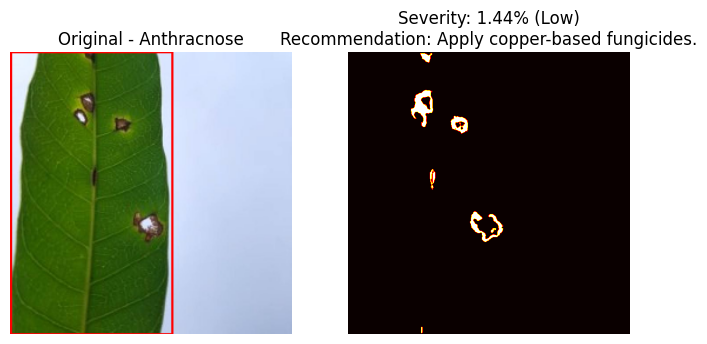

Processing completed.


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Correct path for the uploaded image file
image_path = "/kaggle/input/dataset-leaf-severity/test/images/20211011_133419-Custom-_jpg.rf.d91a0617fb7a28d17a0da00b4536d716.jpg"  # Path to the uploaded image

# Load YOLOv11 Model
yolo_model = YOLO("/kaggle/input/best-part-data/detect/train/weights/best.onnx")  # Update with actual model path

# Define disease-specific recommendations
disease_recommendations = {
    "Anthracnose": {
        "Low": "Apply copper-based fungicides.",
        "Medium": "Prune infected parts and apply fungicides.",
        "High": "Severely infected leaves should be removed immediately."
    },
    "Powdery Mildew": {
        "Low": "Use neem oil spray as a preventive measure.",
        "Medium": "Apply sulfur-based fungicides.",
        "High": "Quarantine affected plants and apply systemic fungicides."
    },
    "Sooty Mould": {
        "Low": "Wash leaves with mild soap solution.",
        "Medium": "Introduce natural predators like ladybugs.",
        "High": "Apply horticultural oils to remove mold."
    },
    "Gall Midge": {
        "Low": "Use insecticidal soap for control.",
        "Medium": "Remove affected areas and apply neem-based pesticides.",
        "High": "Apply systemic insecticides for severe infestations."
    },
    "Bacterial Canker": {
        "Low": "Apply copper-based sprays.",
        "Medium": "Remove infected branches and disinfect tools.",
        "High": "Apply bactericides and consider tree removal if necessary."
    },
    "Healthy": {"None": "Maintain good agricultural practices."}
}

# Function to classify severity level
def classify_severity(severity):
    if severity == 0:
        return "None"
    elif severity <= 20:
        return "Low"
    elif severity <= 50:
        return "Medium"
    else:
        return "High"

# Process a single image
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Error loading image.")

# Run YOLOv11 model for disease detection
results_yolo = yolo_model(image)
disease_name = "Healthy"
for r in results_yolo:
    if len(r.boxes) > 0:
        disease_name = r.names[int(r.boxes.cls[0].item())]
        for box in r.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get coordinates of the bounding box
            confidence = box.conf[0].item()  # Get confidence score

            # Draw bounding box (Red color for better visibility)
            image = cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 3)

            # Add confidence score text on the image (Black text)
            label = f"{disease_name}: {confidence*100:.2f}%"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7  # Control the size of the font
            font_thickness = 2
            text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
            text_w, text_h = text_size

            # Draw a filled rectangle behind the text for better visibility (White background)
            image = cv2.rectangle(image, (int(x1), int(y1) - 20), (int(x1) + text_w, int(y1) - 20 - text_h), (255, 255, 255), -1)
            
            # Now place the text over the filled rectangle (Black text)
            image = cv2.putText(image, label, (int(x1), int(y1) - 10), font, font_scale, (0, 0, 0), font_thickness)

# Convert to HSV and apply thresholding for infected area segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower = np.array([15, 60, 30])
upper = np.array([35, 255, 255])
infected_mask = cv2.inRange(hsv, lower, upper)
infected_pixels = cv2.countNonZero(infected_mask)

# Convert to grayscale and detect leaf area
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
leaf_mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
leaf_pixels = cv2.countNonZero(leaf_mask)

# Calculate severity percentage
severity = (infected_pixels / leaf_pixels) * 100 if leaf_pixels > 0 else 0
severity_level = classify_severity(severity)

# Get recommendation
recommendations = disease_recommendations.get(disease_name, {"None": "No data available."})
recommendation = recommendations.get(severity_level, "No treatment needed.")

# Display image, severity, and recommendation
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Use cv2.cvtColor to convert BGR to RGB
plt.title(f"Original - {disease_name}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(infected_mask, cmap='hot')
plt.title(f"Severity: {severity:.2f}% ({severity_level})\nRecommendation: {recommendation}")
plt.axis("off")

plt.show()

print("Processing completed.")
